In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier

In [2]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from util import calculate_weights, train_validation_test_split, get_statistics
from dataset import DatasetGenerator
from custom_transforms import ShuffleChannel
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from models import PretrainedModel, resnet18
from sklearn.metrics import f1_score

In [3]:
from skorch.callbacks import LRScheduler
import torch.optim as optim
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from collections import Counter

In [4]:
import iflai

#### Set all random seeds to the specific value, so the results are more reproducable

In [5]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

#### Define all necessary parameters

In [6]:
dataset_name = "wbc"
selected_channels = np.arange(12)
path_to_data ="..\..\data/WBC"
model_dir = "models_remote"
scaling_factor = 4095.
reshape_size = 64
num_channels = len(selected_channels)
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]
channels =np.asarray([ "Ch" + str(i) for i in selected_channels])

In [7]:
batch_size = 64
num_workers = 2
device="cpu"

#### Load data

In [8]:
%time

metadata = iflai.metadata_generator(path_to_data)

Wall time: 0 ns
Metadata prepration starts...
experiment donor condition


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31280/31280 [00:07<00:00, 3945.90it/s]


...metadata prepration ended.


In [9]:
indx = metadata["label"] != "unknown"
metadata = metadata.loc[indx,:]
metadata = metadata.reset_index(drop = True)

#### Split data

In [10]:
train_index, validation_index, test_index = train_validation_test_split(metadata.index, metadata["label"], random_state=seed_value)

In [11]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), np.arange(len(set(metadata.loc[train_index, "label"])))))

In [12]:
label_map

{b'CD14+ monocyte': 0,
 b'CD15+ neutrophil': 1,
 b'CD19+ B': 2,
 b'CD4+ T': 3,
 b'CD56+ NK': 4,
 b'CD8+ T': 5,
 b'NKT': 6,
 b'eosinophil': 7,
 b'unknown': 8}

#### Oversamle and use class weights for imbalance data / Skip if not required

In [13]:
y_train = [label_map.get(metadata.loc[i, "label"]) for i in train_index]
weights = calculate_weights(y_train)
oversample = RandomOverSampler(random_state=seed_value, sampling_strategy='all')

In [ ]:
Counter(y_train)

In [ ]:
train_index, y_train = oversample.fit_resample(np.asarray(train_index).reshape(-1, 1), y_train)
train_index = train_index.T[0]

In [ ]:
Counter(y_train)

#### Calculate statistics of train set and normalize the data

In [14]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

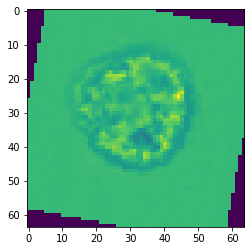

In [16]:
plt.imshow(train_dataset[0][0][0])

In [17]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [04:06<00:00,  1.27it/s]

statistics used: {'min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p25': tensor([0.1921, 0.0032, 0.0139, 0.0049, 0.0071, 0.0090, 0.0103, 0.0079, 0.1888,
        0.0120, 0.0047, 0.0082]), 'p50': tensor([0.1966, 0.0040, 0.0144, 0.0051, 0.0076, 0.0098, 0.0110, 0.0084, 0.1921,
        0.0131, 0.0055, 0.0085]), 'p75': tensor([0.1979, 0.0084, 0.0147, 0.0056, 0.0078, 0.0129, 0.0117, 0.0102, 0.1936,
        0.0141, 0.0063, 0.0088]), 'p95': tensor([0.2090, 0.0649, 0.0156, 0.0062, 0.0084, 0.0486, 0.0280, 0.0249, 0.2049,
        0.0162, 0.0073, 0.0095]), 'p99': tensor([0.2315, 0.1167, 0.0182, 0.0097, 0.0090, 0.1018, 0.0722, 0.0417, 0.2271,
        0.0273, 0.0082, 0.0141]), 'max': tensor([0.3464, 0.7831, 0.0413, 0.0301, 0.0180, 0.7042, 0.2737, 0.1221, 0.3525,
        0.0799, 0.0223, 0.0606]), 'mean': tensor([0.1728, 0.0134, 0.0128, 0.0048, 0.0067, 0.015

In [18]:
train_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [19]:
test_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [20]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

In [21]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
num_classes = len(label_map.keys())

In [23]:
validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

In [24]:
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Set all hyperparameters for the model

In [25]:
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.5)

In [26]:
checkpoint = Checkpoint(
    f_params='wbc_net_all_.pth', monitor='valid_loss_best', dirname='models')
train_end_cp = TrainEndCheckpoint(f_params='final_wbc_net_all_.pth', dirname='models')

In [26]:
class_weights = torch.FloatTensor(weights).to(device)

NameError: name 'weights' is not defined

### Initialite and train the model

In [ ]:
num_classes

In [ ]:
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    #criterion__weight=class_weights,
    lr=0.001,
    batch_size=64,
    max_epochs=10,
    module__output_features=num_classes,
    module__num_classes=num_classes,
    module__num_channels=num_channels, 
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=False,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lrscheduler, checkpoint, train_end_cp],
    train_split=predefined_split(validation_dataset),
    #device='cuda' # comment to train on cpu
)

In [ ]:
net.fit(train_dataset, y=None)

### Model Evaluation

In [27]:
#net.save_params(f_params='final_wbc_net_all_.pth')
model = PretrainedModel(num_classes, num_channels)
checkpoint = torch.load('models/wbc_net_all_.pth')
model.load_state_dict(checkpoint)
model = model.to(device)

In [28]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        #Tracer()()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs)])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [29]:
class_names_targets = [c.decode("utf-8") for c in label_map.keys()]

In [30]:
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=4))

                  precision    recall  f1-score   support

  CD14+ monocyte     0.9697    1.0000    0.9846       256
CD15+ neutrophil     0.9970    0.9986    0.9978      3665
         CD19+ B     0.9886    0.9719    0.9802       178
          CD4+ T     0.9898    0.9788    0.9843       895
        CD56+ NK     0.9917    0.8955    0.9412       134
          CD8+ T     0.9366    0.9497    0.9431       358
             NKT     0.8263    0.7621    0.7929       206
      eosinophil     0.9838    0.9902    0.9870       307
         unknown     0.8058    0.8716    0.8374       257

        accuracy                         0.9767      6256
       macro avg     0.9433    0.9354    0.9387      6256
    weighted avg     0.9769    0.9767    0.9766      6256



### Model Interpretation

In [31]:
# where to save results
model_name = "wbc"

#### Pixel-Permutation Tests

In [32]:
from time import process_time

Candidate channel is 0


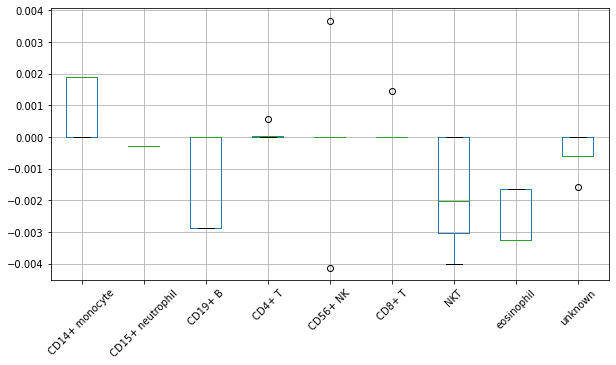

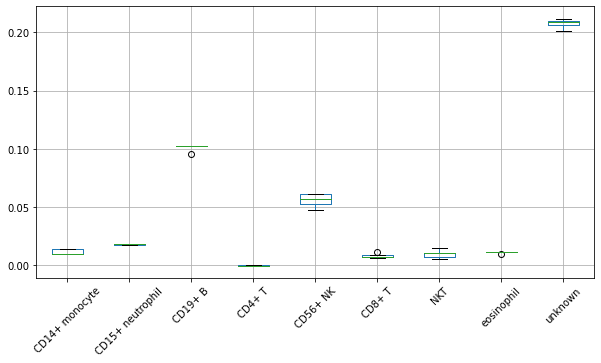

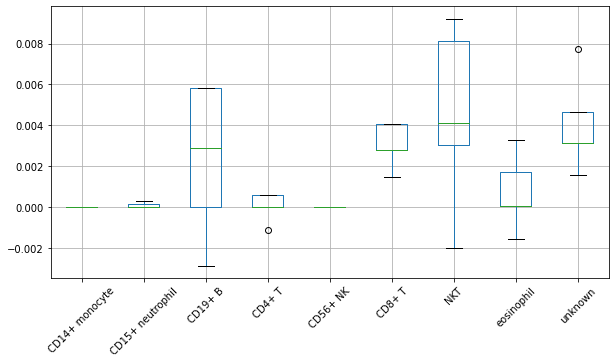

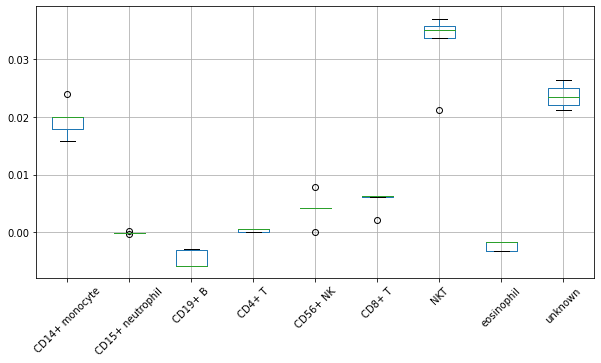

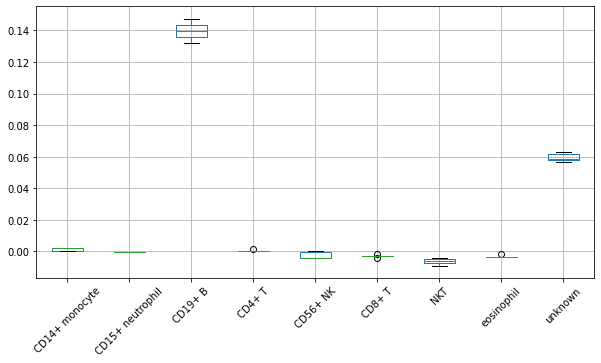

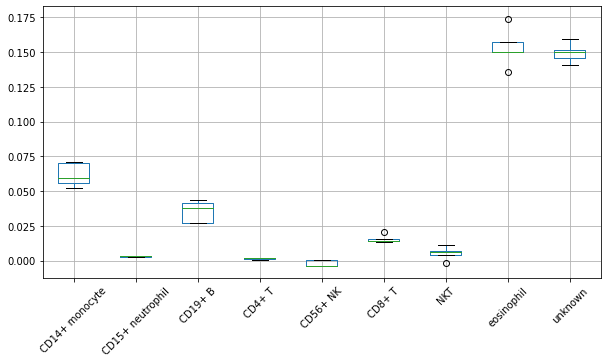

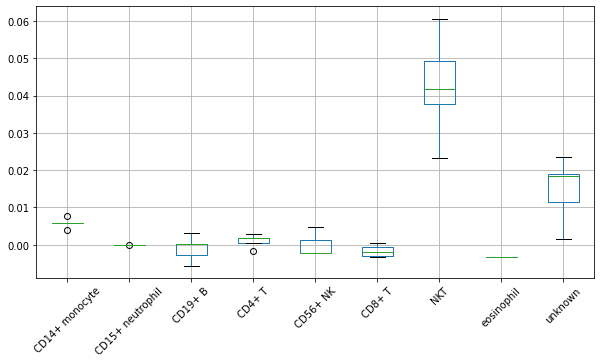

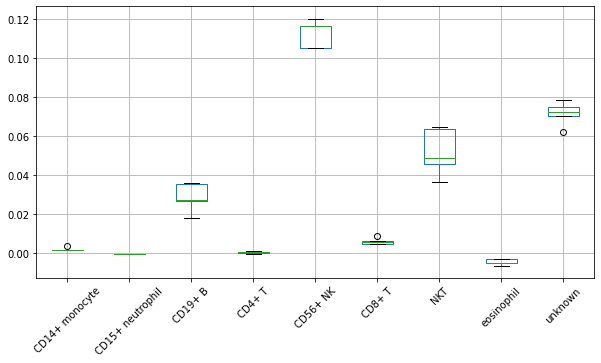

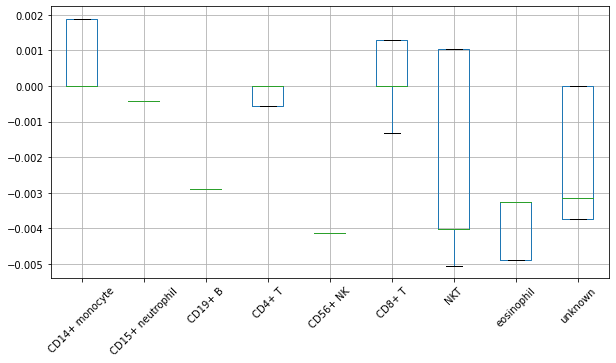

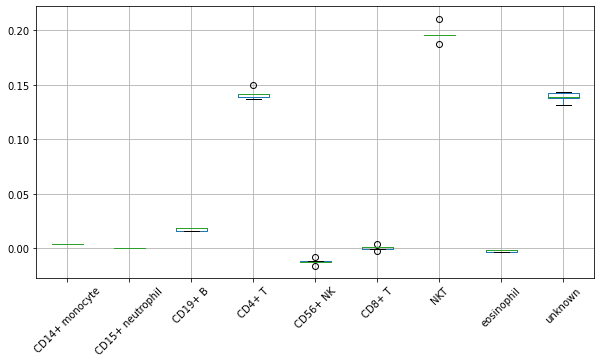

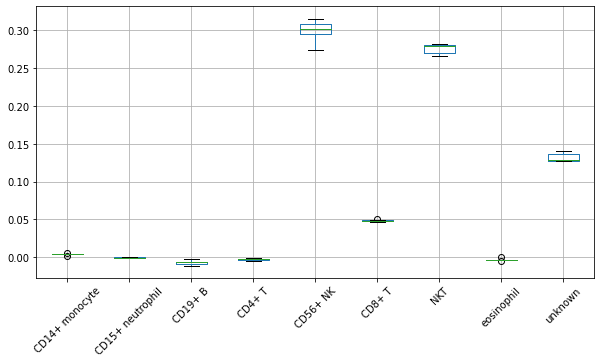

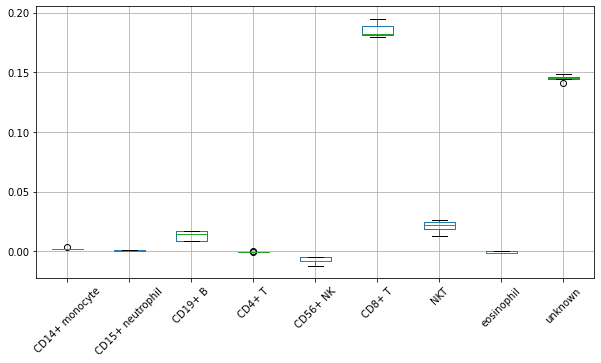

In [33]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in range(shuffle_times):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel is {}".format(candidate))

In [34]:
df_all

,CD14+ monocyte,CD15+ neutrophil,CD19+ B,CD4+ T,CD56+ NK,CD8+ T,NKT,eosinophil,unknown
0,0.001134,-0.000272,-0.001152,0.000121,-0.000092,0.000294,-0.001815,-0.002605,-0.000556
1,0.011454,0.018154,0.101029,-0.000315,0.055983,0.008017,0.009528,0.011087,0.207658
2,0.0,0.000081,0.002328,0.000004,0.0,0.003034,0.004501,0.000702,0.004045
3,0.019511,-0.000109,-0.004704,0.000346,0.00407,0.005446,0.03257,-0.002312,0.023644
4,0.001134,-0.000273,0.139804,0.000571,-0.002573,-0.002894,-0.006263,-0.002918,0.059603
5,0.061637,0.003052,0.035438,0.001376,-0.002037,0.015627,0.005297,0.153514,0.149612
6,0.005812,-0.000109,-0.001039,0.001033,-0.000097,-0.001696,0.042528,-0.003247,0.014715
7,0.002266,-0.000301,0.028743,0.00035,0.112677,0.006148,0.051868,-0.00449,0.071712
8,0.000756,-0.000409,-0.002881,-0.000225,-0.004136,0.000261,-0.0022,-0.003901,-0.002124
9,0.00392,0.0,0.017367,0.141706,-0.012167,0.000717,0.196971,-0.002284,0.13872


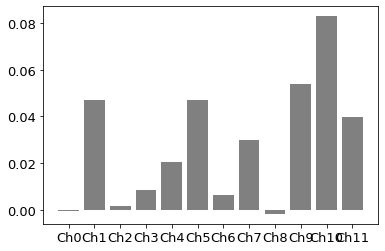

In [55]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [36]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [37]:
channel_ranking_pixel_permutation

,channels,importance
0,Ch0,-0.000549
1,Ch1,0.046955
2,Ch2,0.001633
3,Ch3,0.008718
4,Ch4,0.020688
5,Ch5,0.047057
6,Ch6,0.006433
7,Ch7,0.029886
8,Ch8,-0.001651
9,Ch9,0.053884


### Evaluate the method with AOPC

In [38]:
def calculate_aopc(channel_ranking, method='', ascending=False, plot=True, perturb=False):
    #channel_ranking = pd.DataFrame(data={"channels":channels_ranking, "importance": importance})
    sorted_channels = channel_ranking.sort_values(by="importance", ascending=ascending)
    channels_to_permute=[]
    differences = []
    # calculate (f^0 - f^k)
    for i in range(len(sorted_channels)):
        channels_to_permute.append(np.where(channels==sorted_channels.iloc[i]["channels"])[0][0])
        transform = test_transform.copy()
        transform.append(ShuffleChannel(channels_to_shuffle=channels_to_permute, perturb=perturb))
        dataset_ = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader_ = DataLoader(dataset_,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        
        y_true_permut_proba = list()
        with torch.no_grad():
            for data in dataloader_:
                inputs, labels = data[0].to(device).float(), data[1].to(device).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                permut_proba = np.array([j[i] for (i,j) in zip(pred, outputs)])
                _, predicted = torch.max(outputs.data, 1)
                for i in range(len(pred)):
                    y_true_permut_proba.append(permut_proba[i].item())
        differences.append(y_true_proba-np.array(y_true_permut_proba))
    stacked_diff = np.stack(differences)
    # calculate summ(f^0-f^k)
    diff_accumulated = []
    for idx, diff in enumerate(stacked_diff):
        if idx==0:
            diff_accumulated.append(stacked_diff[idx])
        else:
            diff_accumulated.append(diff_accumulated[idx-1] + stacked_diff[idx])
    diff_accumulated = np.stack(diff_accumulated)
    # mean over the test set
    diff_accumulated_mean = np.mean(diff_accumulated, axis=-1)
    # divide by 1/L+1
    diff_accumulated_mean_norm = np.array([])
    for ix, d in enumerate(diff_accumulated_mean):
        diff_accumulated_mean_norm = np.append(diff_accumulated_mean_norm, d/(ix+1))
    # insert (0,0)
    diff_accumulated_mean_norm_started_from_0 = np.insert(diff_accumulated_mean_norm,0,0.0)
    # plot line
    if plot:
        x = np.arange(len(diff_accumulated_mean_norm_started_from_0))
        plt.xlabel("permutation steps")
        plt.ylabel("AOPC")
        plt.plot(x, diff_accumulated_mean_norm_started_from_0, color ="red")
        #plt.show()
        plt.savefig(os.path.join("results",model_name, "{}-aopc-{}-{}.svg".format(dataset_name, method, str("resnet_all"))))
    return diff_accumulated_mean_norm_started_from_0

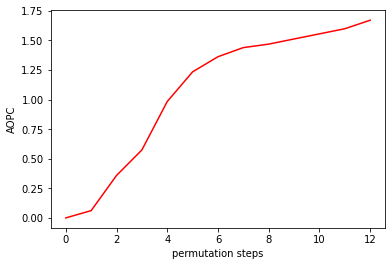

In [39]:
res_pixel_permutated_perturb_reverse = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-perturb', perturb=True, ascending=False)

### Interpretation by methods from captum

In [40]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [41]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

#### Occlusion

In [ ]:
occl = Occlusion(model)
heatmaps_occl_mean = run_interpretation_method(occl, 'Occlusion', require_sliding_window=True)

In [ ]:
channel_ranking_occlusion = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_occl_mean.cpu().numpy()})
res_pixel_occl_perturb_reverse = calculate_aopc(channel_ranking_occlusion, method='occlusion-aopc', ascending=False, perturb=True)

#### DeepLift

Elapsed time: 11448.15625 10429.171875
Elapsed time during the whole program in seconds: 1018.984375


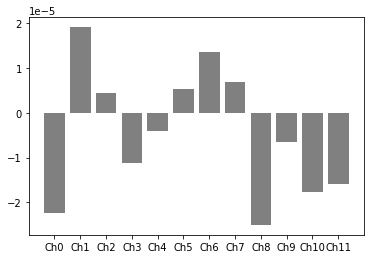

In [42]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')

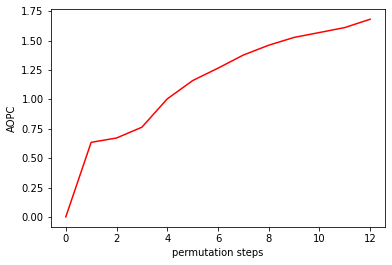

In [43]:
channel_ranking_deep_lift = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_deeplift_mean.cpu().numpy()})
res_deep_lift_perturb_reverse = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-aopc', ascending=False, perturb=True)

#### Saliency

In [ ]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')

In [ ]:
channel_ranking_saliency = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_saliency_mean.cpu().numpy()})
res_saliency_perturb_reverse = calculate_aopc(channel_ranking_saliency, method='saliency-aopc', ascending=False, perturb=True)

#### Integrated Gradients

Elapsed time: 31172.9375 12931.25
Elapsed time during the whole program in seconds: 18241.6875


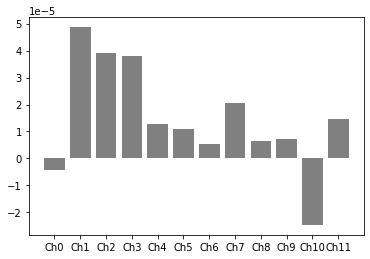

In [44]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')

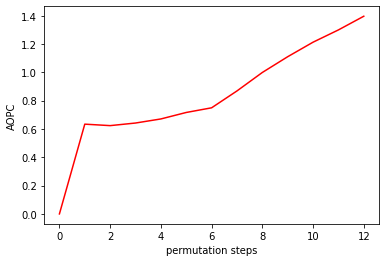

In [45]:
channel_ranking_integrated_gradient = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_integrated_gradient_mean.cpu().numpy()})
res_integrated_gradient_perturb_reverse = calculate_aopc(channel_ranking_integrated_gradient, method='integrated_gradient-aopc', ascending=False, perturb=True)

#### LIME

In [ ]:
lime = Lime(model)
heatmaps_lime_mean = run_interpretation_method(lime, 'Lime')

In [ ]:
channel_ranking_lime = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_lime_mean.cpu().numpy()})
res_lime_mean_perturb_reverse = calculate_aopc(channel_ranking_lime, method='lime-aopc', ascending=False, perturb=True)

#### Deconvolution

In [ ]:
deconv = Deconvolution(model)
heatmaps_deconv_mean = run_interpretation_method(deconv, 'Deconvolution')

In [ ]:
channel_ranking_deconv = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_deconv_mean.cpu().numpy()})
res_deconv_mean_perturb_reverse = calculate_aopc(channel_ranking_deconv, method='deconv-aopc', ascending=False, perturb=True)

#### LRP

In [ ]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')

In [ ]:
channel_ranking_lrp = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_lrp_mean.cpu().numpy()})
res_lrp_mean_perturb_reverse = calculate_aopc(channel_ranking_lrp, method='lrp-aopc', ascending=False, perturb=True)

#### Guided GradCAM

Elapsed time: 33489.09375 32679.75
Elapsed time during the whole program in seconds: 809.34375


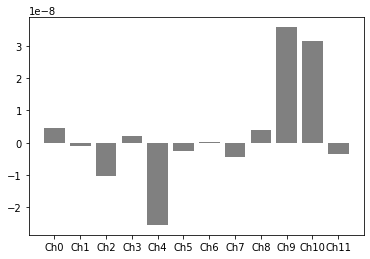

In [46]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')

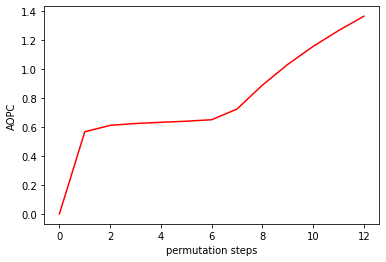

In [47]:
channel_ranking_gradcam = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_gradcam_mean.cpu().numpy()})
res_gradcam_mean_perturb_reverse = calculate_aopc(channel_ranking_gradcam, method='gradcam-aopc', ascending=False, perturb=True)

#### Guided Backprop

In [ ]:
guided_backprop = GuidedBackprop(model)
heatmaps_backprop_mean = run_interpretation_method(guided_backprop, 'GuidedBackprop')

In [ ]:
channel_ranking_backprop = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_backprop_mean.cpu().numpy()})
res_backprop_mean_perturb_reverse = calculate_aopc(channel_ranking_backprop, method='guided_backprop-aopc', ascending=False, perturb=True)

#### DeepLiftShap

In [ ]:
dlshap = DeepLiftShap(model)
heatmaps_dlshap_mean = run_interpretation_method(dlshap, 'DeepLiftShap', require_baseline=True)

In [ ]:
channel_ranking_dlshap = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_dlshap_mean.cpu().numpy()})
res_dlshap_mean_perturb_reverse = calculate_aopc(channel_ranking_dlshap, method='dlshap-aopc', ascending=False, perturb=True)

#### Shapley Value Sampling

In [ ]:
shapley = ShapleyValueSampling(net)
heatmaps_shapley_mean = run_interpretation_method(shapley, 'Shapley')

In [ ]:
channel_ranking_shapley = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_shapley_mean.cpu().numpy()})
res_shapley_mean_perturb_reverse = calculate_aopc(channel_ranking_shapley, method='shapley-aopc', ascending=False, perturb=True)

#### Feature Permutation

In [ ]:
feat_perm = FeaturePermutation(net)
heatmaps_feat_perm_mean = run_interpretation_method(feat_perm, 'FeaturePermutation')

In [ ]:
channel_ranking_feat_perm = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_feat_perm_mean.cpu().numpy()})
res_feat_perm_mean_perturb_reverse = calculate_aopc(channel_ranking_feat_perm, method='feat_permut-aopc', ascending=False, perturb=True)

#### Feature Ablation

In [ ]:
feat_abl = FeatureAblation(net)
heatmaps_feat_abl_mean = run_interpretation_method(feat_abl, 'FeatureAblation')

In [ ]:
channel_ranking_feat_abl = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_feat_abl_mean.cpu().numpy()})
res_feat_abl_mean_perturb_reverse = calculate_aopc(channel_ranking_feat_abl, method='feat_abl-aopc', ascending=False, perturb=True)

#### GradientShap

In [ ]:
gradshap = GradientShap(model)
heatmaps_gradshap_mean = run_interpretation_method(gradshap, 'GradientShap', require_baseline=True)

In [ ]:
channel_ranking_gradshap = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_gradshap_mean.cpu().numpy()})
res_gradshap_mean_perturb_reverse = calculate_aopc(channel_ranking_gradshap, method='gradshap-aopc', ascending=False, perturb=True)

#### Random

In [48]:
channel_ranking_random = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': np.random.randint(len(selected_channels), size=len(selected_channels))})

In [49]:
channel_ranking_random

,channels,importance
0,Ch0,6
1,Ch1,3
2,Ch2,10
3,Ch3,7
4,Ch4,4
5,Ch5,6
6,Ch6,9
7,Ch7,2
8,Ch8,6
9,Ch9,10


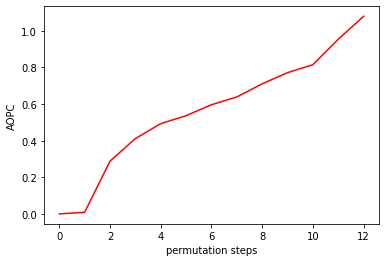

In [50]:
res_random_perturb_reverse = calculate_aopc(channel_ranking_random, method='random-perturb-aopc', ascending=False, perturb=True)

#### Plot all together

In [51]:
x = np.arange(len(res_random_perturb_reverse))

In [52]:
cmap = plt.cm.get_cmap('hsv', 17)

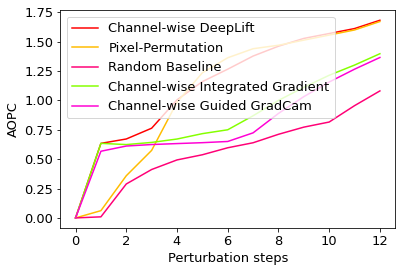

In [54]:
plt.rcParams.update({'font.size': 13})
got_label=False
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", c=cmap(0))
#plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", c=cmap(1))
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", c=cmap(2))
plt.plot(x, res_random_perturb_reverse, label  = "Random Baseline", color=cmap(15))
#plt.plot(x, res_saliency_perturb_reverse, label  = "Channel-wise Saliency", c=cmap(3))
plt.plot(x, res_integrated_gradient_perturb_reverse, label  = "Channel-wise Integrated Gradient", c=cmap(4))
#plt.plot(x, res_lime_mean_perturb_reverse, label  = "Channel-wise LIME", c=cmap(5))
#plt.plot(x, res_deconv_mean_perturb_reverse, label  = "Channel-wise Deconvolution", c=cmap(6))
#plt.plot(x, res_lrp_mean_perturb_reverse, label  = "Channel-wise LRP", c=cmap(7))
#plt.plot(x, res_gradshap_mean_perturb_reverse, label="Channel-wise GradientShap", c=cmap(8))
#plt.plot(x, res_feat_abl_mean_perturb_reverse, label="Channel-wise Feature Ablation", c=cmap(9))
#plt.plot(x, res_feat_perm_mean_perturb_reverse, label="Channel-wise Feature Permutation", c=cmap(10))
#plt.plot(x, res_shapley_mean_perturb_reverse, label="Channel-wise Shapley", c=cmap(11))
#plt.plot(x, res_dlshap_mean_perturb_reverse, label="Channel-wise DeepLiftShap", c=cmap(12))
#plt.plot(x, res_backprop_mean_perturb_reverse, label="Channel-wise Guided Backprop", c=cmap(13))
plt.plot(x, res_gradcam_mean_perturb_reverse, label="Channel-wise Guided GradCam", c=cmap(14))
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-{}.svg".format(dataset_name, str("resnet_all"))))
#plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-{}.png".format(dataset_name, str("resnet_all"))))

##### Calculate the random channel ranking 100 times to estimate the lower und upper bound 

In [ ]:
z=2.576

In [ ]:
upper_border = mean + (z * (std / np.sqrt(len(random_rankings))))

In [ ]:
lower_border = mean - (z * (std / np.sqrt(len(random_rankings))))

In [ ]:
for i in range(100):
    channel_ranking_random = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': np.random.randint(len(selected_channels), size=len(selected_channels))})
    random_rankings.append(calculate_aopc(channel_ranking_random, method='random-perturb-reverse', ascending=False, perturb=True, plot=False))

In [ ]:
plt.rcParams.update({'font.size': 13})
got_label=False
for ranking in random_rankings:
    if not got_label:
        plt.plot(x, ranking, label  = "Random Baseline", color="grey", linewidth=0.5, alpha=0.1)
        got_label=True
    else:
        plt.plot(x, ranking, color="grey", linewidth=0.5, alpha=0.1)
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
#plt.plot(x, res_random_perturb_reverse, label  = "Random Baseline", color="blue")
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.png".format(dataset_name, str("resnet_all"))))